In [1]:
import sgml, sgutil, sgpp, dproc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from proc_v1 import p
from ml_v1 import X_cat, X_num, X_all, target, kf, ss, config
from ml_v1 import xgb_adapter, lgb_adapter, cb_adapter, lr_adapter

In [3]:
sc = sgutil.SGCache('img', 'result', 'model')
df_train = p.fit_transform('data/train.csv').assign(
    Calories_Log = lambda x: np.log(x['Calories'] + 1)
)
df_test = p.transform('data/test.csv')
len(df_train)

750000

# 1. Polynomial Feature Generation & Selection

- 1차, 1 / 1차, 2차, 1차 / 1차, 2차 / 1차, 1차 / 2차, 3차 속성을 만듭니다.
- 전체 속성으로 선형 모델을 학습 시키고, 회귀계수를 봅니다.
- 다중 공선성으로 인해 회귀계수가 커진 케이스가 확인 됐습니다. VIF를 측정하여 속성을 선별합니다.

In [4]:
from itertools import combinations, product

X_r = [i + '_r' for i in X_num]
X_o2 = [(i + '_2' if i == j else i + '_mul_'+ j, (i, j)) for i, j in product(X_num, X_num) if i <= j]
X_1d1 = [(i + '_div_' + j, (i, j)) for i, j in product(X_num, X_num) if i != j]
X_o2d1 = [
    (i + '_div_' + j, (i, j)) for (i, a), j in product(X_o2, X_num) if j not in a 
]
X_o1d2 = [
    (i + '_div_' + j, (i, j)) for i, (j, a) in product(X_num, X_o2) if i not in a 
]

X_o3 = [
    (
        i + '_3' if i == j and j == k else i + '_2_mul_' + k if i == j else i + '_2_mul_' + k if i == k  else j + '_2_mul_' + i if j == k else i + '_mul_' + j + '_mul_' + k,
        (i, j, k)
    )
    for i, j, k in product(X_num, X_num, X_num) if i <= j and i <= k and j <= k
]

In [5]:
var_list = [(1 / df_train[a]).rename(a + '_r') for a in X_num]
var_list.extend([(df_train[a].astype('float32') * df_train[b].astype('float32')).rename(i) for i, (a, b) in X_o2])
var_list.extend([(df_train[a].astype('float32') / df_train[b].astype('float32')).rename(i) for i, (a, b) in X_1d1])
var_list.extend([(df_train[a].astype('float32') * df_train[b].astype('float32') * df_train[c].astype('float32')).rename(i) for i, (a, b, c) in X_o3])

df_sel = dproc.join_and_assign(
    df_train,
    pd.concat(var_list, axis = 1)
)
df_sel = dproc.join_and_assign(
    df_sel,
    pd.concat([(df_sel[a] / df_sel[b]).rename(i) for i, (a, b) in X_o2d1 + X_o1d2], axis = 1)
).assign(
    const = 1
)
df_sel.head()

,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories,Calories_Log,Age_r,...,Body_Temp_div_Height_mul_Weight,Body_Temp_div_Weight_2,Body_Temp_div_Duration_mul_Height,Body_Temp_div_Duration_mul_Weight,Body_Temp_div_Duration_2,Body_Temp_div_Duration_mul_Heart_Rate,Body_Temp_div_Heart_Rate_mul_Height,Body_Temp_div_Heart_Rate_mul_Weight,Body_Temp_div_Heart_Rate_2,const
id,,,,,,,,,,,,,,,,,,,,,
0,True,36,189.0,82.0,26.0,101.0,41.000000,150.0,5.017280,0.027778,...,0.002646,0.006098,0.008344,0.019231,0.060651,0.015613,0.002148,0.004950,0.004019,1
1,False,64,163.0,60.0,8.0,85.0,39.700001,34.0,3.555348,0.015625,...,0.004059,0.011028,0.030445,0.082708,0.620313,0.058382,0.002865,0.007784,0.005495,1
2,False,51,161.0,64.0,7.0,84.0,39.799999,29.0,3.401197,0.019608,...,0.003863,0.009717,0.035315,0.088839,0.812245,0.067687,0.002943,0.007403,0.005641,1
3,True,20,192.0,90.0,25.0,105.0,40.700001,140.0,4.948760,0.050000,...,0.002355,0.005025,0.008479,0.018089,0.065120,0.015505,0.002019,0.004307,0.003692,1
4,False,38,166.0,61.0,25.0,102.0,40.599998,146.0,4.990433,0.026316,...,0.004009,0.010911,0.009783,0.026623,0.064960,0.015922,0.002398,0.006525,0.003902,1


In [6]:
var_list = [(1 / df_test[a]).rename(a + '_r') for a in X_num]
var_list.extend([(df_test[a].astype('float32') * df_test[b].astype('float32')).rename(i) for i, (a, b) in X_o2])
var_list.extend([(df_test[a].astype('float32') / df_test[b].astype('float32')).rename(i) for i, (a, b) in X_1d1])
var_list.extend([(df_test[a].astype('float32') * df_test[b].astype('float32') * df_test[c].astype('float32')).rename(i) for i, (a, b, c) in X_o3])

df_sel_test = dproc.join_and_assign(
    df_test,
    pd.concat(var_list, axis = 1)
)
df_sel_test = dproc.join_and_assign(
    df_sel,
    pd.concat([(df_sel[a] / df_sel[b]).rename(i) for i, (a, b) in X_o2d1 + X_o1d2], axis = 1)
).assign(
    const = 1
)
df_sel_test.head()

,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories,Calories_Log,Age_r,...,Body_Temp_div_Height_2,Body_Temp_div_Height_mul_Weight,Body_Temp_div_Weight_2,Body_Temp_div_Duration_mul_Height,Body_Temp_div_Duration_mul_Weight,Body_Temp_div_Duration_2,Body_Temp_div_Duration_mul_Heart_Rate,Body_Temp_div_Heart_Rate_mul_Height,Body_Temp_div_Heart_Rate_mul_Weight,Body_Temp_div_Heart_Rate_2
id,,,,,,,,,,,,,,,,,,,,,
0,True,36,189.0,82.0,26.0,101.0,41.000000,150.0,5.017280,0.027778,...,0.001148,0.002646,0.006098,0.008344,0.019231,0.060651,0.015613,0.002148,0.004950,0.004019
1,False,64,163.0,60.0,8.0,85.0,39.700001,34.0,3.555348,0.015625,...,0.001494,0.004059,0.011028,0.030445,0.082708,0.620313,0.058382,0.002865,0.007784,0.005495
2,False,51,161.0,64.0,7.0,84.0,39.799999,29.0,3.401197,0.019608,...,0.001535,0.003863,0.009717,0.035315,0.088839,0.812245,0.067687,0.002943,0.007403,0.005641
3,True,20,192.0,90.0,25.0,105.0,40.700001,140.0,4.948760,0.050000,...,0.001104,0.002355,0.005025,0.008479,0.018089,0.065120,0.015505,0.002019,0.004307,0.003692
4,False,38,166.0,61.0,25.0,102.0,40.599998,146.0,4.990433,0.026316,...,0.001473,0.004009,0.010911,0.009783,0.026623,0.064960,0.015922,0.002398,0.006525,0.003902


In [108]:
X_sel = [i for i in df_sel.columns if i not in ('Calories', 'Calories_Log', 'const')]

In [8]:
from sklearn.preprocessing import StandardScaler 
df_sel[X_sel] = StandardScaler().fit_transform(df_sel[X_sel])

In [9]:
result = sgml.cv(df_sel, ss, {'X_num': X_sel}, config, lr_adapter, result_proc = [sgml.lr_learning_result])
rmse_all = result['valid_scores'][0]
rmse_all

Fold:   0%|          | 0/1 [00:00<?, ?it/s]

0.06812648703357553

In [10]:
result['model_result'][0]['coef'].sort_values()

Age_mul_Body_Temp      -2677.607570
Weight_div_Body_Temp   -2300.548245
Heart_Rate_2           -2002.387705
Age_div_Body_Temp      -1874.426188
Body_Temp_mul_Weight   -1743.892062
                           ...     
Height_mul_Weight       2120.462376
Duration_div_Height     2484.250042
Duration_mul_Height     2901.800486
Age                     3203.112360
Weight                  3328.888976
Length: 300, dtype: float64

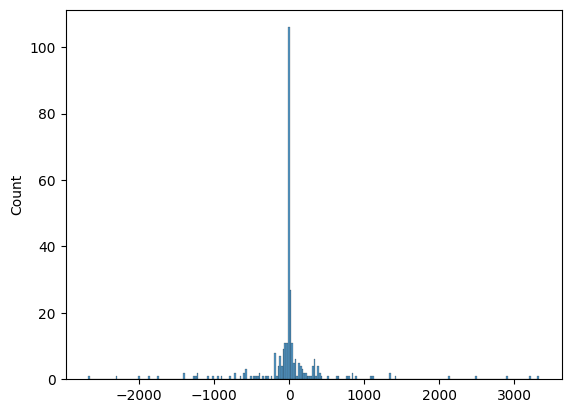

In [11]:
sns.histplot(result['model_result'][0]['coef'])
plt.show()

- 변수가 300개라 모든 변수를 가지고 순차적 선택을 하는 것에는 리소스에 무리가 있었습니다.

- 이를 보완 하기 위해, 차수가 낮은 것에서 시작하여 높은 것으로 그룹핑하여 추가를 해갑니다.

In [10]:
from tqdm.notebook import tqdm
import multiprocessing as mp
from cuml.linear_model import LinearRegression as cu_LinearRegression
lr_c_adapter = sgml.SklearnAdapter(cu_LinearRegression)

def get_rmse_c(X):
    return sgml.cv(df_sel, ss, {'model_params': {'copy_X': True}, 'X_num': X}, {**config, 'progress_callback': None}, lr_c_adapter)['valid_scores'][0]

def fs(X, X_ff):
    return pd.Series(
        {i: get_rmse_c(X + [i]) for i in X_ff if i not in X}
    ).sort_values()
def be(X, floated_list):
    if len(X) < 2: return pd.Series()
    return pd.Series(
        {i: get_rmse_c([j for j in X if j != i]) for i in X[:-1] if i not in floated_list}
    ).sort_values()

def step_fs(X_, X_selected, floated_list, rmse_list):
    while(True):
        s_rmse = fs(X_selected, X_)
        if len(s_rmse) == 0:
            break
        if rmse_list[-1] > s_rmse.iloc[0]:
            rmse_list.append(s_rmse.iloc[0])
            X_selected.append(s_rmse.index[0])
            print("Selected: {}, RMSE: {}".format(X_selected[-1], rmse_list[-1]))
        else:
            break
        while(True):
            s_rmse = be(X_selected, floated_list)
            if len(s_rmse) > 0 and rmse_list[-1] > s_rmse.iloc[0]:
                rmse_list.append(s_rmse.iloc[0])
                floated_list.add(s_rmse.index[0])
                X_selected = [i for i in X_selected if i != s_rmse.index[0]]
                print("Excluded: {}, RMSE: {}".format(s_rmse.index[0], rmse_list[-1]))
            else:
                break
    return X_selected, floated_list, rmse_list

In [11]:
def get_rmse(v):
    i, X = v[0], v[1]
    return i, sgml.cv(df_sel, ss, {'X_num': X}, {**config, 'progress_callback': None}, lr_adapter)['valid_scores'][0]

def fs_mp(X, X_ff):
    X_list = [(i, X + [i]) for i in X_ff if i not in X]
    with mp.Pool(mp.cpu_count()) as pool:
        results = pool.map(get_rmse, X_list)
    return pd.Series(
        {k: v for k, v in results}
    ).sort_values()

def be_mp(X, floated_list):
    if len(X) < 2: return pd.Series()
    X_list = [(i, [j for j in X if j != i]) for i in X[:-1] if i not in floated_list]
    with mp.Pool(mp.cpu_count()) as pool:
        results = pool.map(get_rmse, X_list)
    return pd.Series(
        {k: v for k, v in results}
    ).sort_values()

def step_fs_mp(X_, X_selected, floated_list, rmse_list):
    while(True):
        s_rmse = fs_mp(X_selected, X_)
        if len(s_rmse) == 0:
            break
        if rmse_list[-1] > s_rmse.iloc[0]:
            rmse_list.append(s_rmse.iloc[0])
            X_selected.append(s_rmse.index[0])
            print("Selected: {}, RMSE: {}".format(X_selected[-1], rmse_list[-1]))
        else:
            break
        while(True):
            s_rmse = be_mp(X_selected, floated_list)
            if len(s_rmse) > 0 and rmse_list[-1] > s_rmse.iloc[0]:
                rmse_list.append(s_rmse.iloc[0])
                floated_list.add(s_rmse.index[0])
                X_selected = [i for i in X_selected if i != s_rmse.index[0]]
                print("Excluded: {}, RMSE: {}".format(s_rmse.index[0], rmse_list[-1]))
            else:
                break
    return X_selected, floated_list, rmse_list

In [15]:
X_selected = list()
rmse_list = [np.inf]
X_selected, floated_list, rmse_list = sc.cache_result('fs_o1', lambda : step_fs(X_num, X_selected, set(), rmse_list), rerun = 0)
rmse_list[-1]

0.18064835569722082

In [30]:
X_selected, floated_list, rmse_list = sc.cache_result(
    'fs_r', lambda : step_fs(X_r, X_selected, set(), rmse_list), rerun = 0
)
rmse_list[-1]

0.11890502541192025

In [31]:
X_selected, floated_list, rmse_list = sc.cache_result(
    'fs_o2', lambda : step_fs([i[0] for i in X_o2], X_selected, set(), rmse_list), rerun = 0
)
rmse_list[-1]

0.08281917544819209

In [32]:
X_selected, floated_list, rmse_list = sc.cache_result(
    'fs_1d1', lambda : step_fs([i[0] for i in X_1d1], X_selected, set(), rmse_list), rerun = 0
)
rmse_list[-1]

0.07591978840844088

In [33]:
X_selected, floated_list, rmse_list = sc.cache_result(
    'fs_o2d1', lambda : step_fs_mp([i[0] for i in X_o2d1], X_selected, set(), rmse_list), rerun = 0
)
rmse_list[-1]

0.0718067288948422

In [34]:
X_selected, floated_list, rmse_list = sc.cache_result(
    'fs_o1d2', lambda : step_fs_mp([i[0] for i in X_o1d2], X_selected, set(), rmse_list), rerun = 0
)
rmse_list[-1]

0.07070597741714742

In [35]:
X_selected, floated_list, rmse_list = sc.cache_result(
    'fs_o3', lambda : step_fs_mp([i[0] for i in X_o3], X_selected, set(), rmse_list), rerun = 0
)
rmse_list[-1]

0.07054807770710889

In [36]:
result = sgml.cv(df_sel, ss, {'X_num': X_selected}, config, lr_adapter, result_proc = [sgml.lr_learning_result])
result['valid_scores']

Fold:   0%|          | 0/1 [00:00<?, ?it/s]

[0.07054807770711112]

In [21]:
len(X_selected), np.array(X_selected)

(98,
 array(['Body_Temp', 'Duration', 'Duration_2', 'Body_Temp_mul_Duration',
        'Body_Temp_mul_Weight', 'Weight_2', 'Age_mul_Height',
        'Body_Temp_div_Duration', 'Weight_div_Heart_Rate',
        'Age_div_Weight', 'Heart_Rate_div_Body_Temp',
        'Weight_div_Duration', 'Body_Temp_div_Weight', 'Height_div_Age',
        'Weight_2_div_Heart_Rate', 'Duration_2_div_Body_Temp',
        'Heart_Rate_2_div_Duration', 'Weight_2_div_Age',
        'Height_mul_Weight_div_Body_Temp', 'Height_mul_Weight_div_Age',
        'Age_mul_Weight_div_Height', 'Age_mul_Height_div_Weight',
        'Body_Temp_mul_Heart_Rate_div_Duration',
        'Heart_Rate_2_div_Body_Temp', 'Heart_Rate_2_div_Weight',
        'Weight_2_div_Duration', 'Duration_mul_Heart_Rate_div_Body_Temp',
        'Duration_2_div_Heart_Rate', 'Body_Temp_2_div_Weight',
        'Height_2_div_Body_Temp', 'Age_2_div_Heart_Rate',
        'Age_mul_Weight_div_Duration', 'Heart_Rate_mul_Weight_div_Age',
        'Age_mul_Weight_div_Heart_R

In [37]:
pd.Series(result['model_result'][0]['coef']).sort_values()

Body_Temp_mul_Duration            -628.440215
Height_mul_Weight_div_Body_Temp    -55.189597
Duration_div_Body_Temp_2           -46.878210
Duration_2_div_Body_Temp           -45.344002
Heart_Rate_div_Body_Temp           -42.269036
                                      ...    
Weight_div_Body_Temp_2              52.618924
Body_Temp_mul_Weight                76.852817
Duration_2                          86.418111
Body_Temp_2_mul_Duration           238.878689
Duration                           472.902968
Length: 98, dtype: float64

In [ ]:
from sklearn.linear_model import Lasso
result = sgml.cv(df_sel, ss, {'model_params': {'alpha': 1e-6, 'max_iter': 2000}, 'X_num': X_sel}, config, sgml.SklearnAdapter(Lasso), result_proc = [sgml.lr_learning_result])
result['valid_scores']

In [ ]:
sns.histplot(result['model_result'][0]['coef'])
plt.show()

In [40]:
from sklearn.linear_model import Ridge
result = sgml.cv(df_sel, ss, {'model_params': {'alpha': 1e-3}, 'X_num': X_sel}, config, sgml.SklearnAdapter(Ridge), result_proc = [sgml.lr_learning_result])
result['valid_scores']

Fold:   0%|          | 0/1 [00:00<?, ?it/s]

[0.068523406731391]

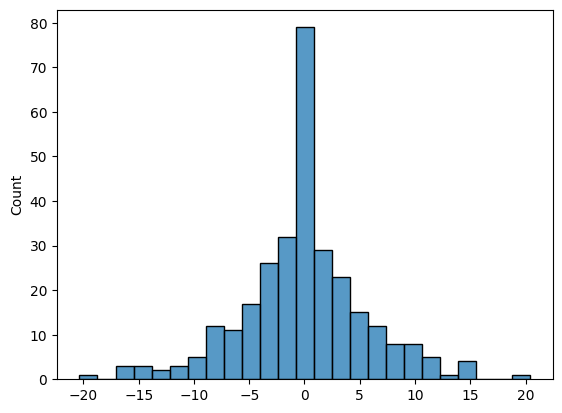

In [41]:
sns.histplot(result['model_result'][0]['coef'])
plt.show()

In [42]:
pd.Series(result['model_result'][0]['coef']).sort_values()

Heart_Rate                              -20.365835
Body_Temp_2_mul_Duration                -16.865307
Heart_Rate_2_mul_Duration               -16.786587
Heart_Rate_div_Body_Temp                -15.564463
Weight_2_mul_Body_Temp                  -14.918791
                                           ...    
Body_Temp_mul_Duration_mul_Heart_Rate    14.198431
Age_mul_Height_mul_Weight                14.302717
Body_Temp_div_Heart_Rate_2               14.497902
Heart_Rate_2_div_Body_Temp               15.153733
Heart_Rate_2_mul_Body_Temp               20.439106
Length: 300, dtype: float64

- Ridge로 회귀계수의 크기를 줄일 수 있지만 성능도 같이 줄어드니다.

- Backward Eliminations를 사용해봅니다.

In [ ]:
def be_mp2(X, floated_list):
    if len(X) < 2: return pd.Series()
    X_list = [(i, [j for j in X if j != i]) for i in X if i not in floated_list]
    results = {}
    for k, v in tqdm(X_list):
        results[k] = get_rmse_c(v)
    return pd.Series(results).sort_values()

el = list()
rmse_list = [get_rmse_c(X_sel)]
cnt = 0
while(True):
    s_rmse = sc.cache_result(
        'be_{}'.format(cnt), lambda : be_mp2([i for i in X_sel if i not in el], set())
    )
    cnt += 1
    if len(s_rmse) > 0 and rmse_list[-1] > s_rmse.iloc[0]:
        rmse_list.append(s_rmse.iloc[0])
        el.append(s_rmse.index[0])
        print("Excluded: {}, RMSE: {}".format(el[-1], rmse_list[-1]))
    else:
        break

- 성능의 개선 여지가 크지 않습니다.

- 공선성이 큰 속성을 제외해봅니다.

In [12]:
from sklearn.metrics import r2_score
import gc
def get_r2(X_var):
    r2_scores = list()
    for i in tqdm(X_var):
        X_ = [j for j in X_var if j != i]
        r2_scores.append(
            r2_score(
                df_sel[i], cu_LinearRegression(copy_X = True).fit(df_sel[X_], df_sel[i]).predict(df_sel[X_])
            )
        )
        gc.collect()
    return pd.Series(r2_scores, index = X_var).sort_values(ascending = False)

- 원래 변수들 간의 다중 공선성을 조사합니다.

In [15]:
get_r2(X_num)

  0%|          | 0/6 [00:00<?, ?it/s]

Weight        0.921672
Height        0.921273
Duration      0.882499
Body_Temp     0.816003
Heart_Rate    0.766673
Age           0.048410
dtype: float64

- Weight와 Height가 공선성이 강합니다.

In [16]:
get_r2([i for i in X_num if i != 'Weight'])

  0%|          | 0/5 [00:00<?, ?it/s]

Duration      0.882476
Body_Temp     0.815981
Heart_Rate    0.766543
Height        0.002123
Age           0.001859
dtype: float64

In [17]:
get_r2([i for i in X_num if i not in ['Weight', 'Duration']])

  0%|          | 0/4 [00:00<?, ?it/s]

Body_Temp     0.634442
Heart_Rate    0.633830
Height        0.001938
Age           0.001230
dtype: float64

In [12]:
import numpy as np
from numpy.linalg import inv

def r2_fast(X, use_const = True):
    n, p = X.shape
    if use_const:
        p -= 1
    # Step 2: Compute Gram matrix and its inverse
    G = X.T @ X
    G_inv = inv(G)

    r2s = np.zeros(p)

    for j in range(p):
        # Step 3: Extract alpha = (G_inv)_{jj}
        alpha = G_inv[j, j]

        # Step 4: Variance of x_j (centered)
        var_j = np.var(X[:, j], ddof=0) * n  # multiply by n because G = X.T @ X

        # Step 5: R² calculation using Schur complement identity
        r2 = 1 - (1 / (alpha * var_j))
        r2s[j] = r2

    return r2s

def r2_sc(X):
    return pd.Series(
        r2_fast(df_sel[X + ['const']].values), index = X
    ).sort_values(ascending = False)

In [69]:
r2_sc(X_num)

Weight        0.921672
Height        0.921273
Duration      0.882499
Body_Temp     0.816003
Heart_Rate    0.766673
Age           0.048410
dtype: float64

In [70]:
r2_sc([i for i in X_num if i != 'Weight'])

Duration      0.882476
Body_Temp     0.815981
Heart_Rate    0.766543
Height        0.002123
Age           0.001859
dtype: float64

- r2_fast 이용하여 변수를 포함 시켰을 때 공선성이 적은 변수를 골라 포함시켜갑니다.

In [25]:
def get_var_to_eliminate(X_tgt, threshold = 0.99):
    el = {}
    for i in range(len(X_tgt)):
        s_r2 = r2_sc([i for i in X_tgt if i not in el])
        if s_r2.iloc[0] > threshold:
            el[s_r2.index[0]] = s_r2.iloc[0]
        else:
            break
    return pd.Series(el)

In [72]:
s_exc = sc.cache_result(
    'exc_r2', lambda : get_var_to_eliminate(X_sel, 0.8)
)

In [73]:
result = sgml.cv(df_sel, ss, {'X_num': [i for i in X_sel if i not in s_exc.index[:50]]}, config, lr_adapter, result_proc = [sgml.lr_learning_result])
result['valid_scores']

Fold:   0%|          | 0/1 [00:00<?, ?it/s]

[0.06824796234140333]

In [74]:
result = sgml.cv(df_sel, ss, {'X_num': [i for i in X_sel if i not in s_exc.index[:100]]}, config, lr_adapter, result_proc = [sgml.lr_learning_result])
result['valid_scores']

Fold:   0%|          | 0/1 [00:00<?, ?it/s]

[0.06878948232552616]

In [75]:
result = sgml.cv(df_sel, ss, {'X_num': [i for i in X_sel if i not in s_exc.index[:200]]}, config, lr_adapter, result_proc = [sgml.lr_learning_result])
result['valid_scores']

Fold:   0%|          | 0/1 [00:00<?, ?it/s]

[0.07018588114062105]

In [76]:
result = sgml.cv(df_sel, ss, {'X_num': [i for i in X_sel if i not in s_exc.index[:250]]}, config, lr_adapter, result_proc = [sgml.lr_learning_result])
result['valid_scores']

Fold:   0%|          | 0/1 [00:00<?, ?it/s]

[0.07401156122859467]

In [77]:
result = sgml.cv(df_sel, ss, {'X_num': [i for i in X_sel if i not in s_exc.index[:270]]}, config, lr_adapter, result_proc = [sgml.lr_learning_result])
result['valid_scores']

Fold:   0%|          | 0/1 [00:00<?, ?it/s]

[0.07777651286116688]

In [78]:
result = sgml.cv(df_sel, ss, {'X_num': [i for i in X_sel if i not in s_exc.index[:290]]}, config, lr_adapter, result_proc = [sgml.lr_learning_result])
result['valid_scores']

Fold:   0%|          | 0/1 [00:00<?, ?it/s]

[0.2554399056147664]

In [79]:
result = sgml.cv(df_sel, ss, {'pca': {'X_num': X_sel, 'hparams': {'n_components': 0.9999}}}, config, lr_adapter, result_proc = [sgml.lr_learning_result])
result['valid_scores']

Fold:   0%|          | 0/1 [00:00<?, ?it/s]

[0.07398964134988695]

In [13]:
import numpy as np
from numpy.linalg import inv

def lm_fs_fast(X_all, y, base_vars, use_const = True):
    n, p = X_all.shape
    if use_const:
        p -= 1
    X_base = X_all[:, base_vars]
    G_inv = inv(X_base.T @ X_base)
    b = X_base.T @ y
    total_var = np.sum((y - y.mean()) ** 2)

    r2s = {}
    base_set = set(base_vars)
    for j in range(p):
        if j in base_set:
            continue

        xj = X_all[:, j:j + 1]# (n,1)
        B = X_base.T @ xj
        C = xj.T @ X_base 
        D = xj.T @ xj

        # s = Schur complement
        G_inv_new = (C @ G_inv)
        S = D - (G_inv_new @ B)
        
        if S[0][0] <= 1e-10:
            r2s[j] = np.nan  # ill-conditioned
            continue

        G_inv_new_lower = -G_inv_new / S
        G_inv_updated = np.block([
            [G_inv + G_inv_new.T @ G_inv_new / S, G_inv_new_lower.T],
            [G_inv_new_lower, 1 / S]
        ])
        b_new = np.hstack((b, xj.T @ y))
        beta_new = G_inv_updated @ b_new    
        X_full = np.hstack([X_base, xj])
        y_pred = (X_full @ beta_new).flatten()
        ss_res = np.sum((y - y_pred) ** 2)
        r2 = 1 - ss_res / total_var
        r2s[j] = r2
    return r2s

def lm_el_fast(X, y, use_const = True):
    n, p = X.shape
    ids = np.arange(p)
    if use_const:
        p -= 1
    G_inv = inv(X.T @ X)
    b = X.T @ y
    total_var = np.sum((y - y.mean()) ** 2)
    r2s = np.zeros(p)
    
    for j in range(p):
        idx = ids != j

        # Extract M, alpha, v from full G_inv
        M = G_inv[np.ix_(idx, idx)] # (p-1)x(p-1)
        v = G_inv[idx, j].reshape(-1, 1)# (p-1)x1
        alpha = G_inv[j, j]# scalar
        # Schur-complement-based inverse of G_sub
        G_sub_inv = M - (v @ v.T) / alpha

        # b_sub for beta
        b_sub = b[idx].reshape(-1, 1) # (p-1)x1
        beta_sub = (G_sub_inv @ b_sub).flatten()  # (p-1)x1

        # Predict y using X_{-j}
        y_pred = X[:, idx] @ beta_sub
        ss_res = np.sum((y - y_pred) ** 2)
        r2s[j] = 1 - ss_res / total_var

    return r2s

In [14]:
lm_el_fast(df_sel[X_num + X_r + ['const']].values, df_sel[target])

array([0.98424252, 0.98493251, 0.98474077, 0.96857929, 0.98407143,
       0.98403994, 0.98489252, 0.9849285 , 0.98466392, 0.98294217,
       0.98192726, 0.98390105])

In [ ]:
from sklearn.linear_model import LinearRegression
for i in X_num:
    X_lr = [j for j in X_num if i != j]
    reg_lr = LinearRegression()
    print(
        i, r2_score(
            df_sel[target],
            reg_lr.fit(df_sel[X_lr], df_sel[target]).predict(df_sel[X_lr])
        ),
        reg_lr.coef_
    )

In [15]:
import numpy as np
from numpy.linalg import inv
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error

def lm_fs_fast2(X_all, y, base_vars, use_const = True, train_size = 0.8, random_state = 123):
    n, p = X_all.shape
    X_train, X_test, y_train, y_test = train_test_split(X_all, y, train_size = train_size, random_state = random_state)
    if use_const:
        p -= 1
        base_vars.append(-1)
    X_base = X_train[:, base_vars]
    G_inv = inv(X_base.T @ X_base)
    b = X_base.T @ y_train
    
    metric = {}
    base_set = set(base_vars)
    for j in range(p):
        if j in base_set:
            continue

        xj = X_train[:, j:j + 1]# (n,1)
        B = X_base.T @ xj
        C = xj.T @ X_base 
        D = xj.T @ xj

        # s = Schur complement
        G_inv_new = (C @ G_inv)
        S = D - (G_inv_new @ B)
        
        if S[0][0] <= 1e-10:
            metric[j] = np.inf
            continue

        G_inv_new_lower = -G_inv_new / S
        G_inv_updated = np.block([
            [G_inv + G_inv_new.T @ G_inv_new / S, G_inv_new_lower.T],
            [G_inv_new_lower, 1 / S]
        ])
        b_new = np.hstack((b, xj.T @ y_train))
        beta_new = (G_inv_updated @ b_new).flatten()
        X_full = np.hstack([X_test[:, base_vars], X_test[:, j:j + 1]])
        y_pred = X_full @ beta_new
        metric[j] = root_mean_squared_error(y_test, y_pred)
    return metric

def lm_el_fast2(X, y, use_const = True, train_size = 0.8, random_state = 123):
    n, p = X.shape
    ids = np.arange(p)
    if use_const:
        p -= 1
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = train_size, random_state = random_state)
    G_inv = inv(X_train.T @ X_train)
    b = X_train.T @ y_train
    metric = np.zeros(p)

    for j in range(p):
        idx = ids != j

        # Extract M, alpha, v from full G_inv
        M = G_inv[np.ix_(idx, idx)] # (p-1)x(p-1)
        v = G_inv[idx, j].reshape(-1, 1)# (p-1)x1
        alpha = G_inv[j, j]# scalar
        # Schur-complement-based inverse of G_sub
        G_sub_inv = M - (v @ v.T) / alpha

        # b_sub for beta
        b_sub = b[idx].reshape(-1, 1) # (p-1)x1
        beta_sub = (G_sub_inv @ b_sub).flatten()  # (p-1)x1

        # Predict y using X_{-j}
        y_pred = X_test[:, idx] @ beta_sub
        metric[j] = root_mean_squared_error(y_test, y_pred)
    return metric

In [276]:
lm_fs_fast2(df_sel[X_num + ['const']].values, df_sel[target].values, [0])

{1: 0.9566583034828902,
 2: 0.9570454555022977,
 3: 0.3126439697518508,
 4: 0.44204050576575,
 5: 0.279972405998011}

In [277]:
from sklearn.linear_model import LinearRegression
for i in X_num[1:]:
    X_lr = X_num[:1] + [i]
    reg_lr = LinearRegression()
    print(
        i, root_mean_squared_error(
            df_sel[target],
            reg_lr.fit(df_sel[X_lr], df_sel[target]).predict(df_sel[X_lr])
        ),
        reg_lr.coef_
    )

Height 0.9555175993522554 [ 0.11465777 -0.04205298]
Weight 0.9558706751306756 [ 0.11659742 -0.03315575]
Duration 0.3126898288335705 [0.10000086 0.90399528]
Heart_Rate 0.4428472346214227 [0.09970873 0.84786619]
Body_Temp 0.27937654047327976 [0.08644798 0.91514942]


In [16]:
def fs_fast(X, X_ff):
    return pd.Series(
        lm_fs_fast2(df_sel[X_ff + ['const']].values, df_sel[target], [X_ff.index(i) for i in X]).values(),
        index = [i for i in X_ff if i not in X]
    ).sort_values()

def be_fast(X, floated_list):
    if len(X) < 2: return pd.Series()
    return pd.Series(
        lm_el_fast2(df_sel[X + ['const']].values, df_sel[target]), index = X
    ).pipe(lambda x: x.loc[~x.index.isin(floated_list)]).sort_values()

def step_fs_fast(X_, X_selected, floated_list, rmse_list):
    while(True):
        s_rmse = fs_fast(X_selected, X_)
        if len(s_rmse) == 0:
            break
        if rmse_list[-1] > s_rmse.iloc[0]:
            rmse_list.append(s_rmse.iloc[0])
            X_selected.append(s_rmse.index[0])
            print("Selected: {}, RMSE: {}".format(X_selected[-1], rmse_list[-1]))
        else:
            break
        while(True):
            s_rmse = be_fast(X_selected, floated_list)
            if len(s_rmse) > 0 and rmse_list[-1] > s_rmse.iloc[0]:
                rmse_list.append(s_rmse.iloc[0])
                floated_list.add(s_rmse.index[0])
                X_selected = [i for i in X_selected if i != s_rmse.index[0]]
                print("Excluded: {}, RMSE: {}".format(s_rmse.index[0], rmse_list[-1]))
            else:
                break
    return X_selected, floated_list, rmse_list

In [17]:
X_selected = list()
rmse_list = [np.inf]
X_selected, floated_list, rmse_list = sc.cache_result(
    'fs_fast2', lambda : step_fs_fast(X_sel, X_selected, set(), rmse_list)
)

Selected: Body_Temp_3, RMSE: 0.29194583475809605
Selected: Heart_Rate_r, RMSE: 0.21644125237000833
Selected: Duration_div_Heart_Rate_2, RMSE: 0.18563290043731107
Selected: Weight_div_Age_mul_Duration, RMSE: 0.13657937269435363
Selected: Age_2_mul_Weight, RMSE: 0.12231856224994818
Selected: Age_mul_Heart_Rate_div_Duration, RMSE: 0.11192458652342319
Selected: Weight_div_Duration_2, RMSE: 0.09700882047505267
Selected: Heart_Rate_mul_Weight_div_Duration, RMSE: 0.09326222977758161
Selected: Age_2_mul_Duration, RMSE: 0.09112012561397806
Selected: Sex, RMSE: 0.08900797793040437
Selected: Age_mul_Weight_div_Body_Temp, RMSE: 0.08685662204768173
Selected: Body_Temp_div_Heart_Rate_2, RMSE: 0.085382044850202
Selected: Body_Temp_div_Heart_Rate_mul_Weight, RMSE: 0.08401816683744795
Selected: Heart_Rate_mul_Weight_div_Age, RMSE: 0.08115503451499735
Selected: Age_2_div_Duration, RMSE: 0.07979954497726144
Selected: Duration_2_div_Weight, RMSE: 0.07871427499718182
Selected: Duration_mul_Heart_Rate_div_H

In [19]:
len(X_selected)

69

In [20]:
result = sgml.cv(df_sel, ss, {'X_num': X_selected}, config, lr_adapter, result_proc = [sgml.lr_learning_result])
result['valid_scores']

Fold:   0%|          | 0/1 [00:00<?, ?it/s]

[0.06920401255309504]

In [23]:
result['model_result'][0]['coef'].sort_values()

Heart_Rate_div_Body_Temp     -76.237514
Heart_Rate_r                 -65.694487
Heart_Rate_3                 -18.656378
Body_Temp_2_div_Heart_Rate   -17.029563
Heart_Rate_mul_Weight        -14.130126
                                ...    
Body_Temp_r                   14.797729
Body_Temp_mul_Weight          23.437684
Heart_Rate                    28.704176
Body_Temp_div_Heart_Rate      46.861580
Heart_Rate_2_div_Body_Temp    62.494575
Length: 69, dtype: float64

In [40]:
s_r2 = get_var_to_eliminate(X_selected, 0.0)

Heart_Rate_div_Body_Temp     1.000000e+00
Body_Temp_div_Heart_Rate     1.000000e+00
Body_Temp_mul_Weight         1.000000e+00
Heart_Rate_div_Weight        1.000000e+00
Weight_div_Heart_Rate        9.999999e-01
                                 ...     
Weight_2_mul_Duration        5.530733e-01
Heart_Rate_2_div_Height      1.678805e-01
Height_div_Age_2             3.731778e-03
Sex                          4.261296e-04
Heart_Rate_div_Duration_2    1.998401e-15
Length: 69, dtype: float64

In [90]:
s_r2.sort_values().iloc[:5]

Heart_Rate_div_Duration_2    1.998401e-15
Sex                          4.261296e-04
Height_div_Age_2             3.731778e-03
Heart_Rate_2_div_Height      1.678805e-01
Weight_2_mul_Duration        5.530733e-01
dtype: float64

In [88]:
result = sgml.cv(df_sel, ss, {'X_num': s_r2.sort_values().index[:5].tolist()}, config, lr_adapter, result_proc = [sgml.lr_learning_result])
result['valid_scores']

Fold:   0%|          | 0/1 [00:00<?, ?it/s]

[0.2633030048179551]

In [89]:
result['model_result'][0]['coef'].sort_values()

Heart_Rate_div_Duration_2   -0.253247
Sex                         -0.101416
Height_div_Age_2            -0.075208
Heart_Rate_2_div_Height      0.464296
Weight_2_mul_Duration        0.468421
dtype: float64

- Log 변환과, SQRT 속성을 추가합니다. 


In [94]:
X_log = [i + '_log' for i in X_num]
X_sqrt_d = [i + '_sqrt_d' for i in X_num]
X_sqrt = [
    (i + '_sqrt' if i == j else i + '_div_' + j + '_sqrt_d', (i, j + '_sqrt_d')) for i, j in product(X_num, X_num)
]
var_list = [np.log(df_train[a]).rename(a + '_log') for a in X_num]
var_list.extend([1 / np.sqrt(df_train[a]).rename(a + '_sqrt_d') for a in X_num])
df_sel = df_sel.join(pd.concat(var_list, axis=1))
var_list = [(df_sel[a] / df_sel[b]).rename(i) for i, (a, b) in X_sqrt]

In [103]:
X_sel += X_log + X_sqrt_d + [i for i, (_,_) in X_sqrt]

In [131]:
df_sel[X_sel] = StandardScaler().fit_transform(df_sel[X_sel])

In [132]:
result = sgml.cv(df_sel, ss, {'X_num': X_sel}, config, lr_adapter, result_proc = [sgml.lr_learning_result])
result['valid_scores']

Fold:   0%|          | 0/1 [00:00<?, ?it/s]

[0.06760522713355314]

In [133]:
X_selected = list()
rmse_list = [np.inf]
X_selected, floated_list, rmse_list = sc.cache_result(
    'fs_fast2_2', lambda : step_fs_fast(X_sel, X_selected, set(), rmse_list)
)

Selected: Duration_log, RMSE: 0.1995965687139265
Selected: Heart_Rate_div_Weight_sqrt_d, RMSE: 0.13789321339098135
Selected: Age_div_Weight_sqrt_d, RMSE: 0.09581795922521598
Selected: Age_mul_Heart_Rate_div_Body_Temp, RMSE: 0.08873191796451296
Selected: Sex, RMSE: 0.08614856646917414
Selected: Body_Temp_div_Heart_Rate_2, RMSE: 0.08353665798322349
Selected: Weight_2_mul_Duration, RMSE: 0.08090936365369668
Selected: Body_Temp_div_Weight_2, RMSE: 0.07954417020216532
Selected: Heart_Rate_div_Body_Temp_mul_Weight, RMSE: 0.07828693506185194
Selected: Body_Temp_div_Duration_2, RMSE: 0.07658472745194643
Selected: Age_2_mul_Height, RMSE: 0.07596016757886773
Selected: Age_mul_Weight_div_Heart_Rate, RMSE: 0.07565809614029395
Selected: Weight_div_Heart_Rate_2, RMSE: 0.07498980718619745
Selected: Age_2_div_Duration, RMSE: 0.0744386026496447
Selected: Age_2_mul_Heart_Rate, RMSE: 0.07427232367345298
Selected: Height_mul_Weight_div_Heart_Rate, RMSE: 0.07400428541445005
Selected: Heart_Rate_mul_Height_

In [134]:
result = sgml.cv(df_sel, ss, {'X_num': X_selected}, config, lr_adapter, result_proc = [sgml.lr_learning_result])
result['valid_scores']

Fold:   0%|          | 0/1 [00:00<?, ?it/s]

[0.06901195100184762]

In [135]:
result['model_result'][0]['coef'].sort_values()

Weight_2                       -382.332152
Heart_Rate                     -161.056265
Heart_Rate_mul_Weight          -100.510612
Heart_Rate_sqrt_d               -87.574503
Weight_sqrt_d                   -72.084118
                                   ...    
Weight_3                         39.050229
Heart_Rate_r                     46.425879
Heart_Rate_div_Weight_sqrt_d     58.461733
Heart_Rate_2                    122.277537
Weight_sqrt                     356.378532
Length: 68, dtype: float64

In [136]:
s_r2 = get_var_to_eliminate(X_selected, 0.0).sort_values()
s_r2

Sex                             0.000011
Age_div_Duration_2              0.000850
Duration_2_mul_Heart_Rate       0.092901
Body_Temp_div_Weight_2          0.633915
Body_Temp_div_Heart_Rate_2      0.665913
                                  ...   
Weight_sqrt                     1.000000
Heart_Rate_sqrt_d               1.000000
Heart_Rate_div_Weight_sqrt_d    1.000000
Heart_Rate                      1.000000
Weight_2                        1.000000
Length: 67, dtype: float64

In [124]:
result = sgml.cv(df_sel, ss, {'X_num': s_r2.sort_values().index[:20].tolist()}, config, lr_adapter, result_proc = [sgml.lr_learning_result])
result['valid_scores']

Fold:   0%|          | 0/1 [00:00<?, ?it/s]

[0.0750261023330266]

In [125]:
result['model_result'][0]['coef'].sort_values()

Height_mul_Weight_div_Heart_Rate     -0.330607
Body_Temp_div_Heart_Rate_2           -0.120001
Weight_2_mul_Age                     -0.101314
Age_mul_Body_Temp_div_Weight         -0.067475
Heart_Rate_3                         -0.055731
Age_2_mul_Height                     -0.045436
Sex                                  -0.035670
Duration_2_mul_Body_Temp             -0.031057
Age_mul_Height_div_Duration          -0.025297
Heart_Rate_mul_Weight_div_Age        -0.008391
Weight_div_Duration_2                -0.003080
Heart_Rate_mul_Height_div_Duration    0.017935
Duration_3                            0.021200
Body_Temp_3                           0.032703
Weight_3                              0.045102
Height_div_Duration_mul_Heart_Rate    0.062403
Heart_Rate_div_Weight_2               0.091598
Heart_Rate_mul_Height_mul_Weight      0.289057
Age_mul_Weight_div_Heart_Rate         0.322951
Duration_log                          1.011359
dtype: float64

In [129]:
X_step_sel = [
    'Duration_log', 'Heart_Rate_div_Weight_sqrt_d', 'Age_div_Weight_sqrt_d',
    'Age_mul_Heart_Rate_div_Body_Temp', 'Sex', 'Body_Temp_div_Heart_Rate_2',  'Weight_2_mul_Duration'
]
result = sgml.cv(df_sel, ss, {'X_num': X_step_sel}, config, lr_adapter, result_proc = [sgml.lr_learning_result])
result['valid_scores']

Fold:   0%|          | 0/1 [00:00<?, ?it/s]

[0.08022250806791238]

In [130]:
result['model_result'][0]['coef'].sort_values()

Age_mul_Heart_Rate_div_Body_Temp   -0.304488
Body_Temp_div_Heart_Rate_2         -0.156461
Sex                                -0.041590
Heart_Rate_div_Weight_sqrt_d        0.018173
Age_div_Weight_sqrt_d               0.045164
Weight_2_mul_Duration               0.046708
Duration_log                        0.916870
dtype: float64